In [1]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

def compareInference(ie,ie2,ax=None):
    """
    compare 2 inference by plotting all the points from (posterior(ie),posterior(ie2))
    """
    exact=[]
    appro=[]
    errmax=0
    for node in bn.ids():
        # potentials as list
        exact+=ie.posterior(node).tolist()
        appro+=ie2.posterior(node).tolist()
        errmax=max(errmax,
                   (ie.posterior(node)-ie2.posterior(node)).abs().max())
    
    if errmax<1e-10: errmax=0
    if ax==None:
        ax=plt.gca() # default axis for plt
           
    ax.plot(exact,appro,'ro')
    ax.set_title("{} vs {}\n {}\nMax error {:2.4} in {:2.4} seconds".format(
        str(type(ie)).split(".")[2].split("_")[0], # name of first inference
        str(type(ie2)).split(".")[2].split("_")[0], # name of second inference
        ie2.messageApproximationScheme(),
        errmax,
        ie2.currentTime())
                )

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
bn=gum.loadBN(os.path.join("res","alarm.dsl"))

ie=gum.LazyPropagation(bn)
ie.makeInference()

In [3]:
gnb.showBN(bn,size='8')


### First, an exact inference.

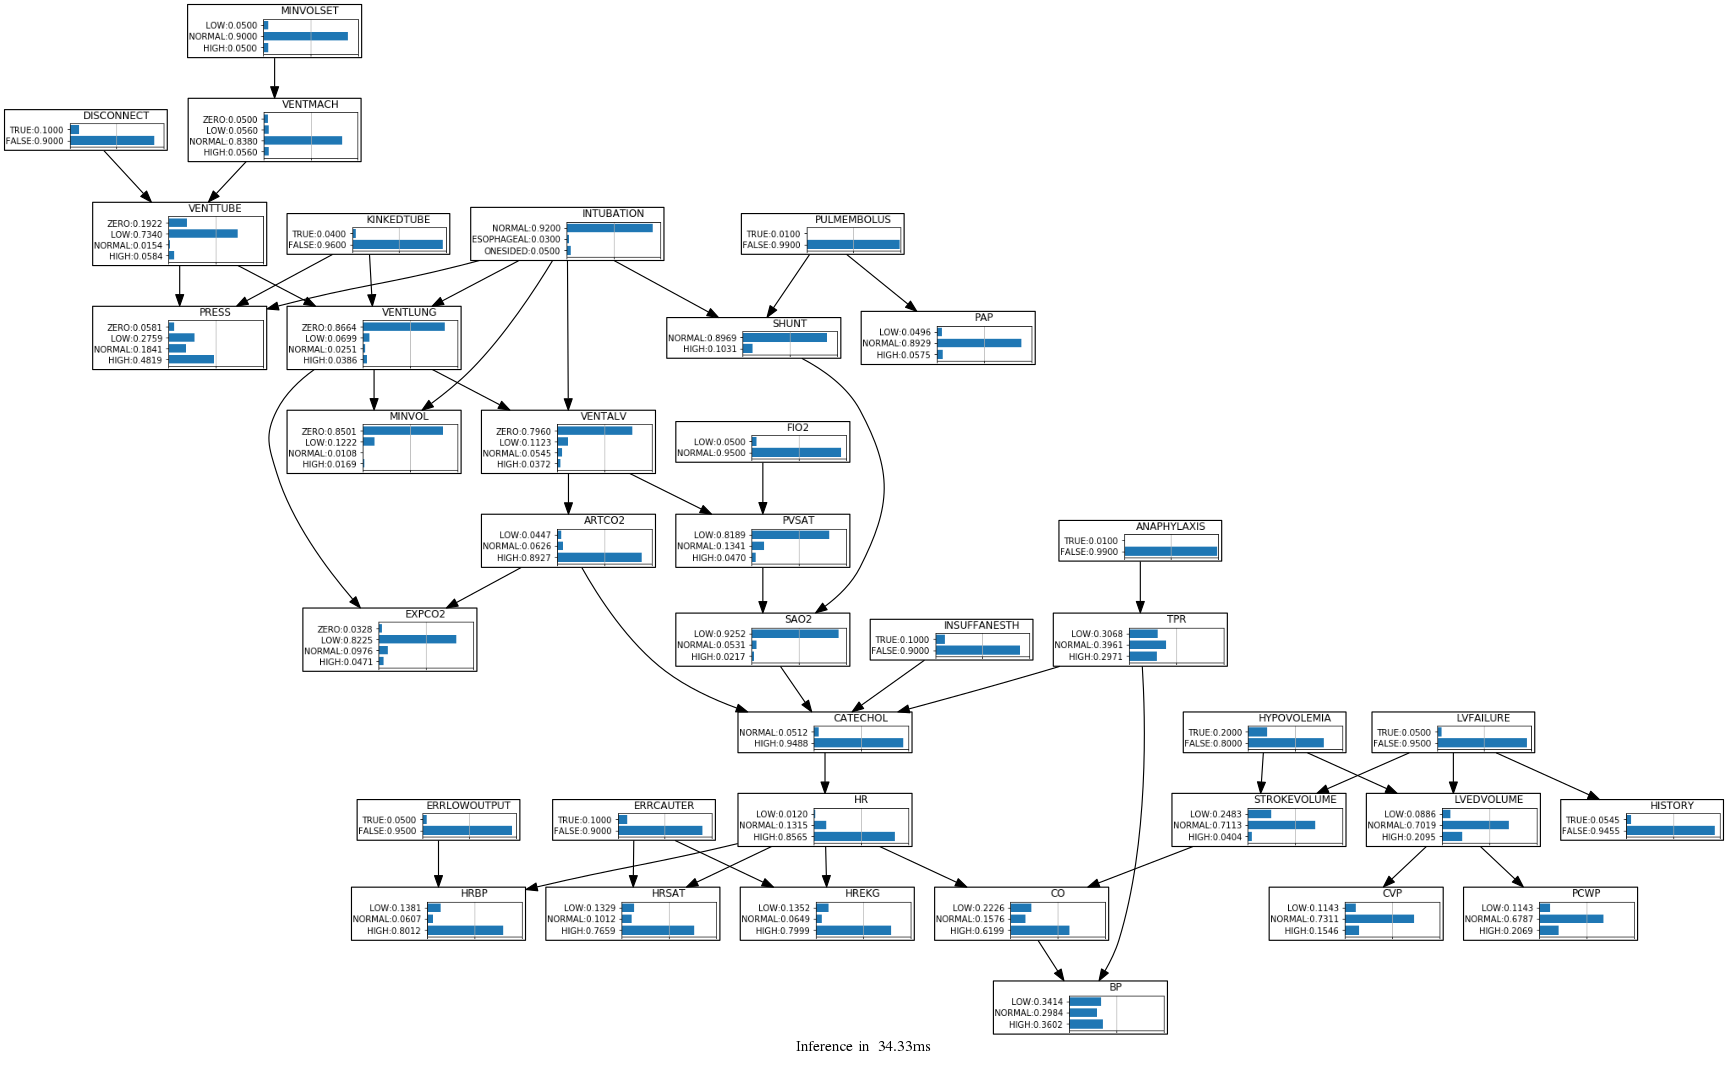

<KINKEDTUBE:TRUE> :: 0.04 /<KINKEDTUBE:FALSE> :: 0.96


In [4]:
gnb.showInference(bn,size="18") # using LazyPropagation by default
print(ie.posterior("KINKEDTUBE"))


<h1>Gibbs Inference</h1>
<h3>Gibbs inference with default parameters</h3>

Gibbs inference iterations can be stopped 
<ul>
<li> by the value of error (epsilon)</li>
<li> by the rate of change of epsilon (MinEpsilonRate)</li>
<li> by the number of iteration (MaxIteration)</li>
<li> by the duration of the algorithm (MaxTime)</li>
</ul>

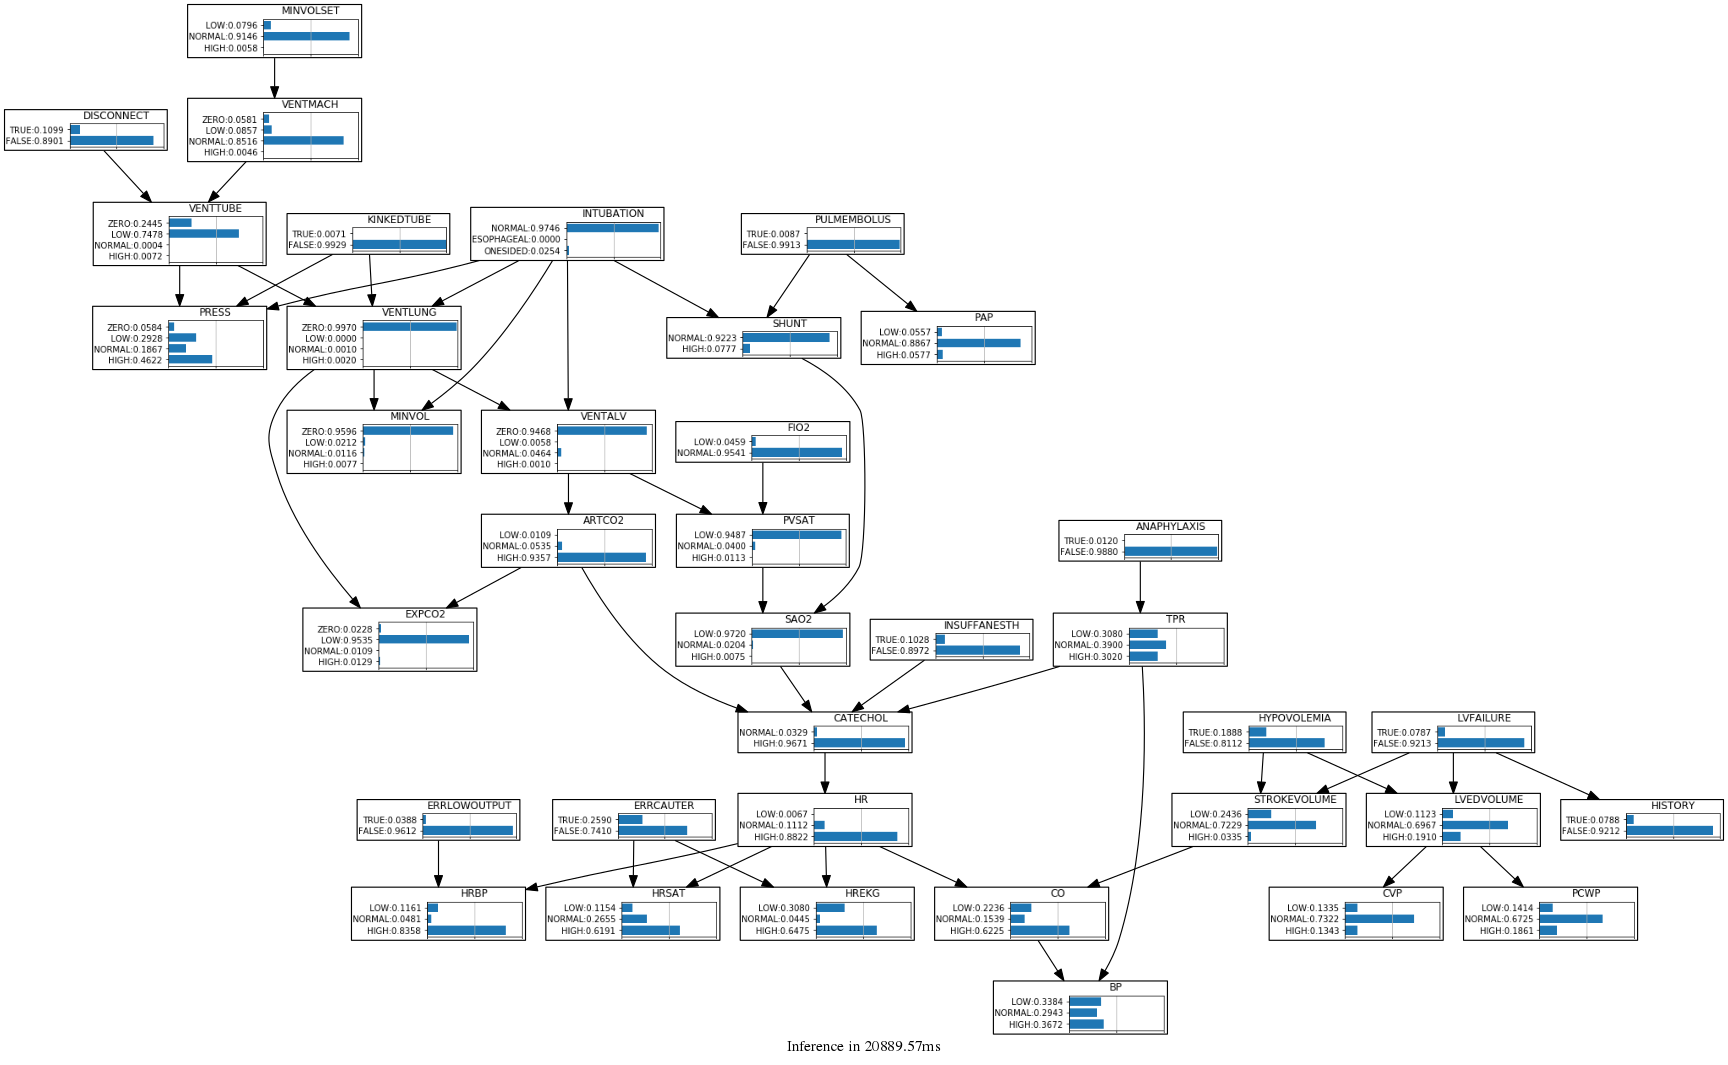

<KINKEDTUBE:TRUE> :: 0.00710145 /<KINKEDTUBE:FALSE> :: 0.992899
stopped with rate=0.00673795


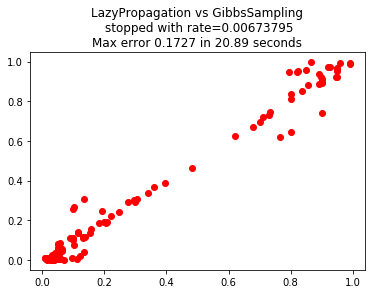

In [5]:
ie2=gum.GibbsSampling(bn)
ie2.setEpsilon(1e-2)
gnb.showInference(bn,engine=ie2,size="18")
print(ie2.posterior("KINKEDTUBE"))
print(ie2.messageApproximationScheme())
compareInference(ie,ie2)

With default parameters, this inference has been stopped by a low value of rate.

### Changing parameters

<INTUBATION:NORMAL> :: 0.915455 /<INTUBATION:ESOPHAGEAL> :: 0 /<INTUBATION:ONESIDED> :: 0.0845455
stopped with max iteration=1000


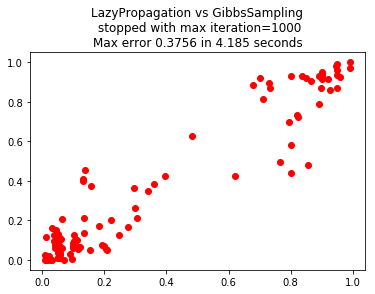

In [6]:
ie2=gum.GibbsSampling(bn)
ie2.setMaxIter(1000)
ie2.setEpsilon(5e-3)
ie2.makeInference()

print(ie2.posterior(2))
print(ie2.messageApproximationScheme())
compareInference(ie,ie2)

<INTUBATION:NORMAL> :: 1 /<INTUBATION:ESOPHAGEAL> :: 0 /<INTUBATION:ONESIDED> :: 0
stopped with epsilon=0.201897


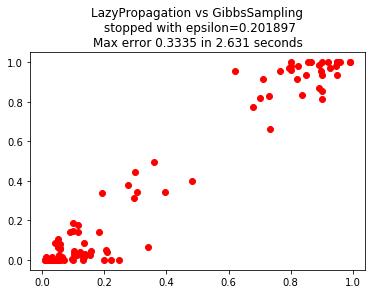

In [7]:
ie2=gum.GibbsSampling(bn)
ie2.setMaxTime(3)
ie2.makeInference()

print(ie2.posterior(2))
print(ie2.messageApproximationScheme())
compareInference(ie,ie2)

### Looking at the convergence

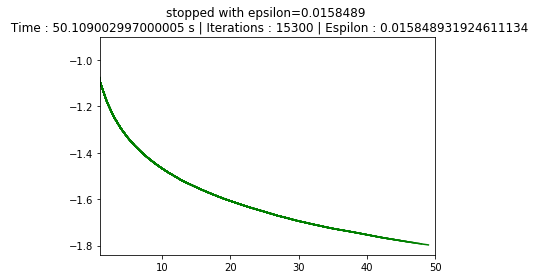

In [8]:
ie2=gum.GibbsSampling(bn)
ie2.setEpsilon(10**-1.8)
ie2.setBurnIn(300)
ie2.setPeriodSize(300)
ie2.setDrawnAtRandom(True)
gnb.animApproximationScheme(ie2)
ie2.makeInference()

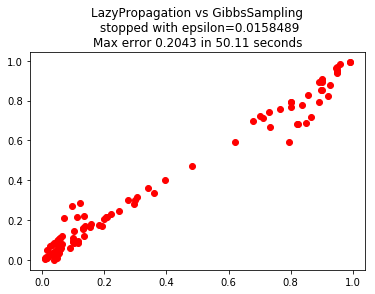

In [9]:
compareInference(ie,ie2)

# Importance Sampling

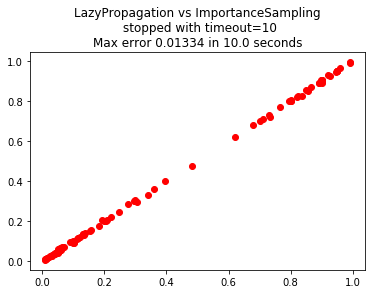

In [10]:
ie4=gum.ImportanceSampling(bn)
ie4.setEpsilon(10**-1.8)
ie4.setMaxTime(10) #10 seconds for inference
ie4.setPeriodSize(300)
ie4.makeInference()
compareInference(ie,ie4)

# Loopy Gibbs Sampling

Every sampling inference has a 'hybrid' version which consists in using a first loopy belief inference as a prior for the probability estimations by sampling.

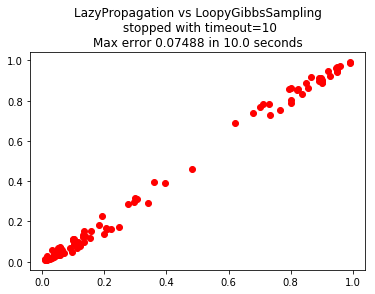

In [11]:
ie3=gum.LoopyGibbsSampling(bn)

ie3.setEpsilon(10**-1.8)
ie3.setMaxTime(10) #10 seconds for inference
ie3.setPeriodSize(300)
ie3.makeInference()
compareInference(ie,ie3)


# Comparison of sampling inference


These computations may be a bit long 

In [12]:
def compareAllInference(bn,evs={},epsilon=10**-1.6,epsilonRate=1e-8,maxTime=20):
    ies=[gum.LazyPropagation(bn),
         gum.LoopyBeliefPropagation(bn),
         gum.GibbsSampling(bn),
         gum.LoopyGibbsSampling(bn),
         gum.WeightedSampling(bn),
         gum.LoopyWeightedSampling(bn),
         gum.ImportanceSampling(bn),
         gum.LoopyImportanceSampling(bn)]
    
    # burn in for Gibbs samplings
    for i in [2,3]:
        ies[i].setBurnIn(300)
        ies[i].setDrawnAtRandom(True)
        
    for i in range(2,len(ies)):
        ies[i].setEpsilon(epsilon)
        ies[i].setMinEpsilonRate(epsilonRate)
        ies[i].setPeriodSize(300)
        ies[i].setMaxTime(maxTime)
        
    for i in range(len(ies)):
        ies[i].setEvidence(evs)
        ies[i].makeInference()
        
    fig, axes = plt.subplots(1,len(ies)-1,figsize=(35, 3),num='gpplot')
    for i in range(len(ies)-1):
        compareInference(ies[0],ies[i+1],axes[i])


## Inference stopped by epsilon


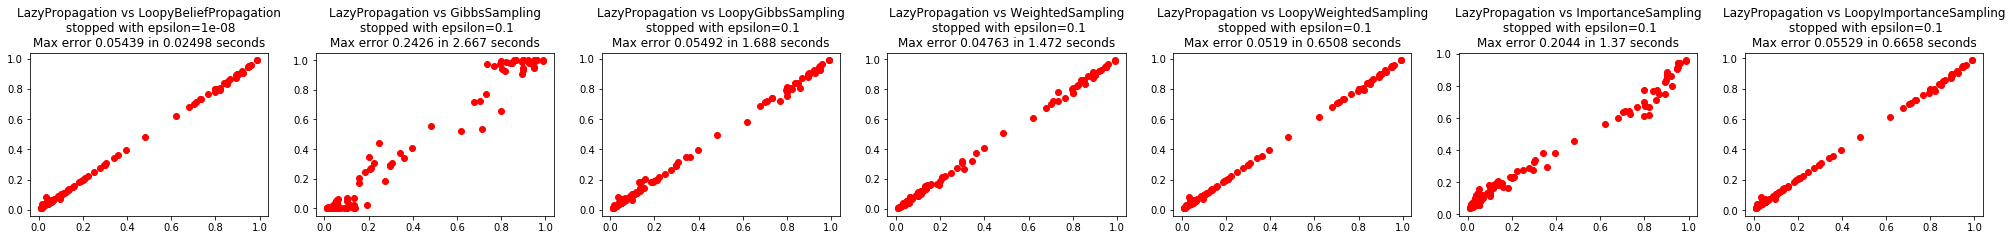

In [13]:
compareAllInference(bn,epsilon=1e-1)

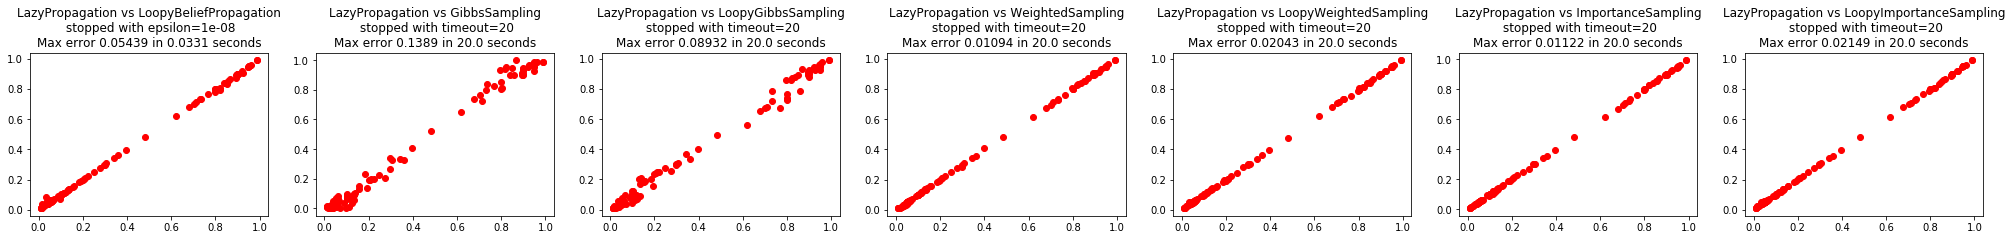

In [14]:
compareAllInference(bn,epsilon=1e-2)

## inference stopped by time

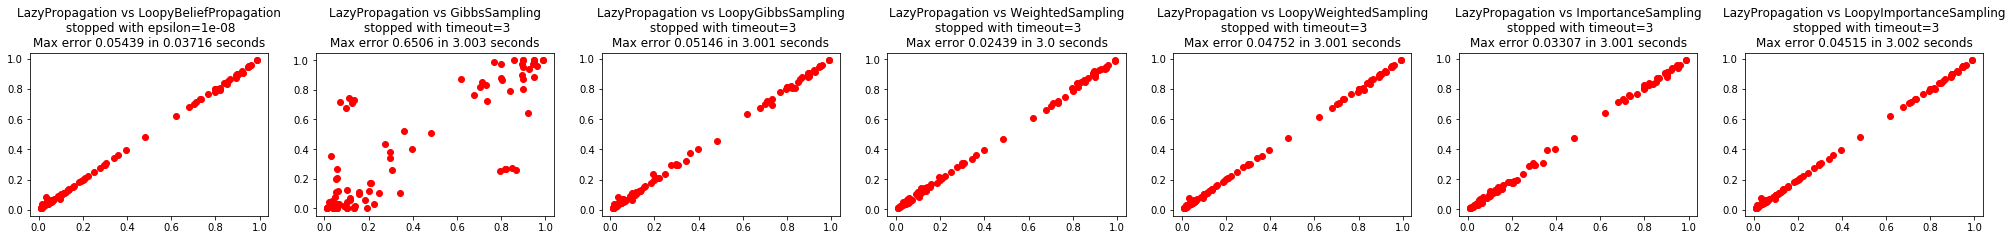

In [15]:
compareAllInference(bn,maxTime=3)

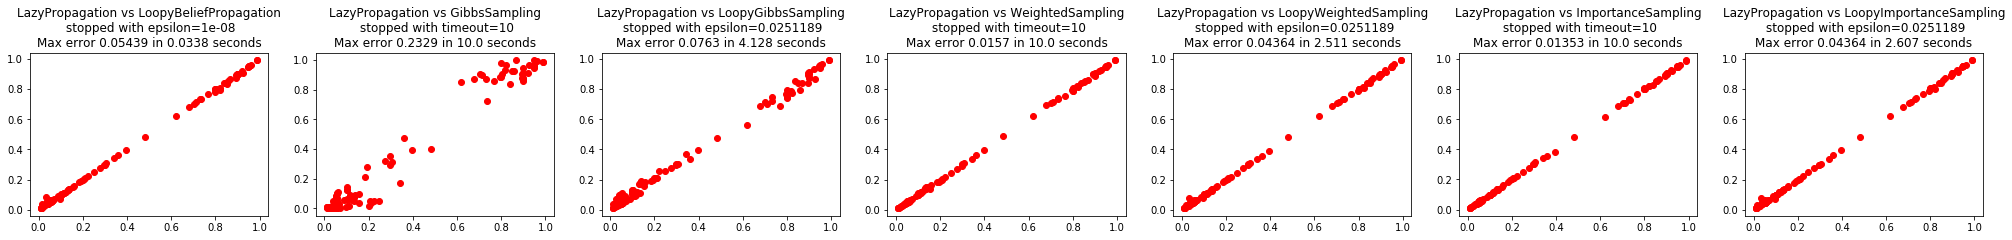

In [16]:
compareAllInference(bn,maxTime=10)

## Inference with Evidence

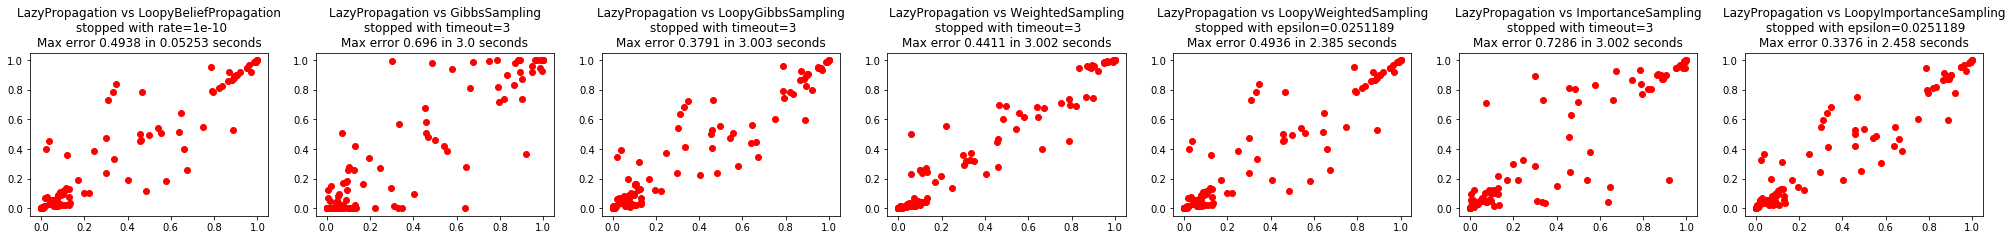

In [17]:
funny={'BP':1,'PCWP':2,'EXPCO2':0}
compareAllInference(bn,maxTime=3,evs=funny)

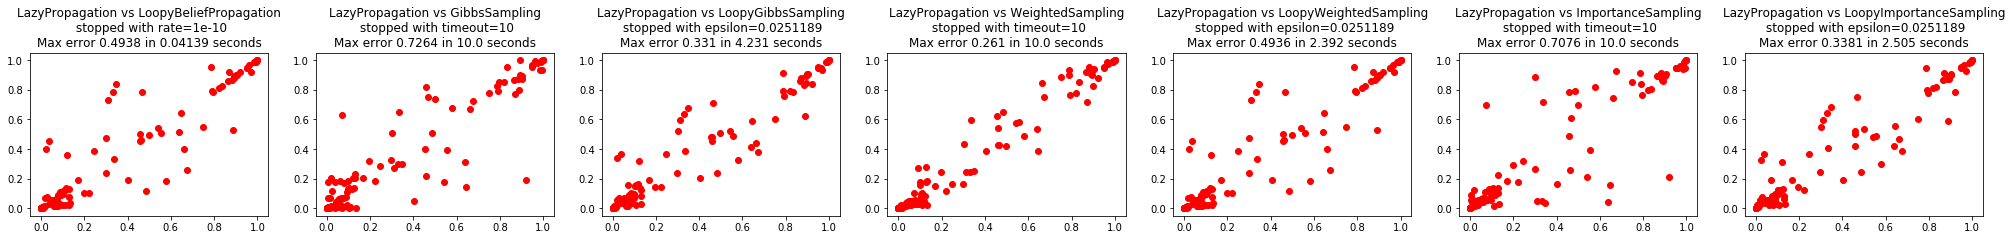

In [18]:
compareAllInference(bn,maxTime=10,evs=funny)

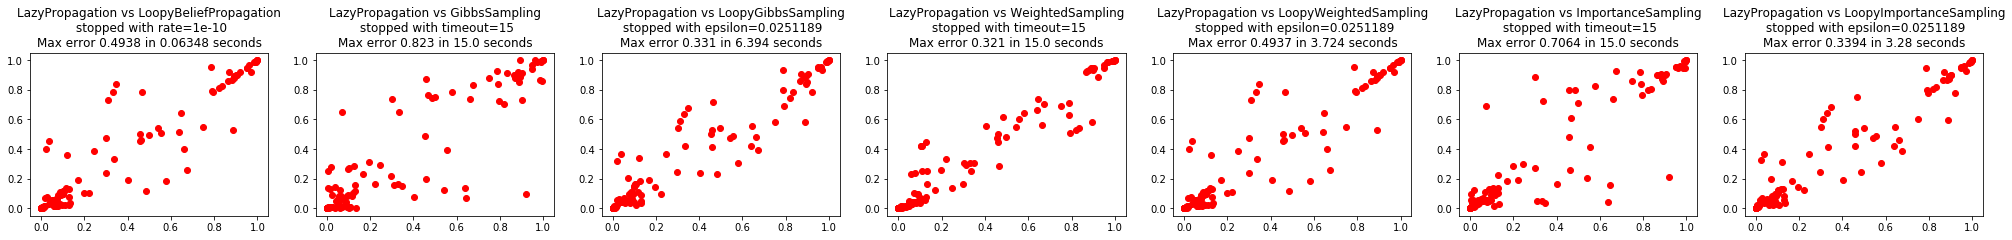

In [19]:
compareAllInference(bn,maxTime=15,evs=funny)

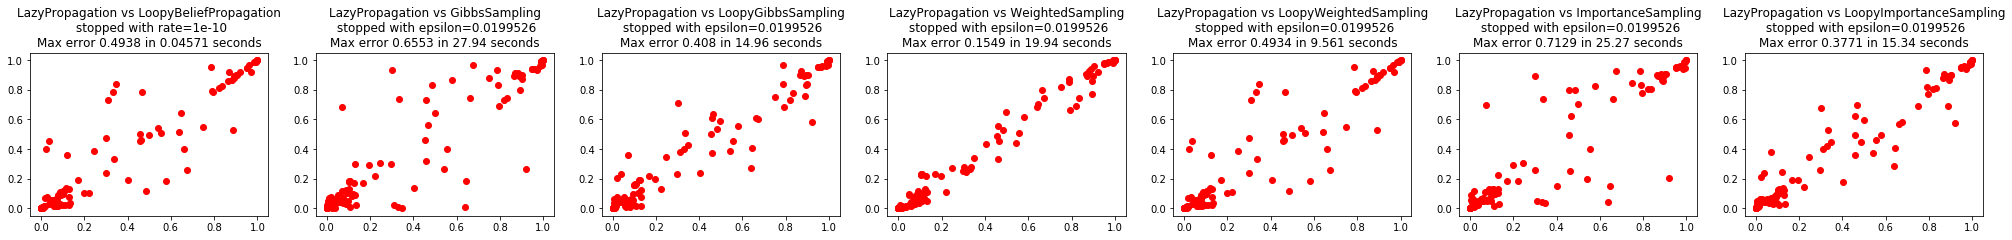

In [20]:
compareAllInference(bn,maxTime=100,epsilon=10**-1.7,evs=funny)